# Text Analysis of Narrative and Probable Cause

# Load all Necesssary Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import re
from pprint import pprint
import string
import nltk
from collections import Counter

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE

# NLTK Stop words
from nltk.corpus import stopwords

# Plotting
import seaborn as sns

# Load combined data generated from RTI_data_exercise_data code

In [43]:
combined_data = pd.read_csv('Downloads/combined_aviation_data.csv')

In [156]:
combined_data['EventDate'][29582]
combined_data['EventDate'][77200]

'01/08/1982'

## Create initial documents list for narrative and probable cause

In [4]:
combined_data['narrative'] = combined_data['narrative'].astype(str)
narrative = combined_data['narrative'].values.tolist()
combined_data['probable_cause'] = combined_data['probable_cause'].astype(str)
cause = combined_data['probable_cause'].values.tolist()
accidentnumber = combined_data['AccidentNumber'].values.tolist()

## Define stop words

In [5]:
stop_words = stopwords.words('english')

## Functions to tokenize, lemmotize, and perform LDA on documents

In [6]:
# Remove punctuation, then tokenize documents
def tokenize(doc):
    punc = re.compile( '[%s]' % re.escape( string.punctuation ) )
    term_vec = [ ]

    for d in doc:
        d = d.lower()
        d = punc.sub( '', d )
        term_vec.append( nltk.word_tokenize( d ) )
    return term_vec

In [7]:
# Lemmotize and remove stopwords 
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)  
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [8]:
# Perform LDA
def LDA(term_vec_processed, num_topics): 
    # Create Dictionary
    id2word = corpora.Dictionary(term_vec_processed)

    # Create Corpus: Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in term_vec_processed]

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics= num_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=10,
                                               passes=10,
                                               alpha='symmetric',
                                               iterations=100,
                                               per_word_topics=True)

    return [lda_model, corpus]

## Functions to plot most common terms in topics and plot document clusters

In [9]:
def plot_topic_words(lda_model, term_vec_processed, x, y):
    topics = lda_model.show_topics(formatted=False)
    data_flat = [w for w_list in term_vec_processed for w in w_list]
    counter = Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(x,y, figsize=(16,10), sharey=True, dpi=160)
    cols = [color for name, color in colors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.show()

In [10]:
def plot_document_topics_labeled(lda_model,corpus,n_topics):
    # Get topic weights
    topic_weights = []
    for i, row_list in enumerate(lda_model[corpus]):
        topic_weights.append([w for i, w in row_list[0]])

    # Array of topic weights    
    arr = pd.DataFrame(topic_weights).fillna(0).values

    # Dominant topic number in each doc
    topic_num = np.argmax(arr, axis=1)

    # tSNE Dimension Reduction
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(arr)

    # Plot the Topic Clusters using Bokeh
    n_topics = n_topics
    fig, ax = plt.subplots(figsize=(25, 15)) # set size
    mycolors = np.array([color for name, color in colors.TABLEAU_COLORS.items()])
    #plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
                  #plot_width=900, plot_height=700)
    ax.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num], s = 150)
    fig.suptitle("t-SNE Clustering of {} LDA Topics".format(n_topics), fontsize=20, y = .9)

    #df = pd.DataFrame(dict(x=tsne_lda[:,0]-.15, y=tsne_lda[:,1]+0.15, label=topic_num, title= names))

    #for i in range(len(df)):
        #ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size = 12)  

    plt.show()

## Text Analytics on Narrative

In [11]:
term_vec_narrative = tokenize(narrative)

In [12]:
term_vec_processed_narrative = process_words(term_vec_narrative)

In [132]:
term_vec_processed_narrative_2000s = term_vec_processed_narrative[0:29582]
term_vec_processed_narrative_1985_2000 = term_vec_processed_narrative[29583:66642]
term_vec_processed_narrative_before_1985 = term_vec_processed_narrative[66643: len(term_vec_processed_narrative)]

In [139]:
term_vec_processed_narrative_joined_2000 = [j for i in term_vec_processed_narrative_2000s for j in i]
term_vec_processed_narrative_joined_1985_2000 = [j for i in term_vec_processed_narrative_1985_2000 for j in i]
term_vec_processed_narrative_joined_before_1985 = [j for i in term_vec_processed_narrative_before_1985 for j in i]

In [145]:
Counter_1 = Counter(term_vec_processed_narrative_joined_2000)
Counter_2 = Counter(term_vec_processed_narrative_joined_1985_2000) 
Counter_3 = Counter(term_vec_processed_narrative_joined_before_1985) 
most_occur_1 = Counter_1.most_common(10) 
most_occur_2 = Counter_2.most_common(10) 
most_occur_3 = Counter_3.most_common(10) 
  
pprint(most_occur_1) 
pprint(most_occur_2) 
pprint(most_occur_3) 

[('airplane', 83246),
 ('pilot', 78548),
 ('accident', 46578),
 ('flight', 38237),
 ('engine', 36567),
 ('aircraft', 34776),
 ('use', 29688),
 ('runway', 28761),
 ('datum', 27526),
 ('landing', 27111)]
[('aircraft', 55215),
 ('pilot', 51820),
 ('accident', 44223),
 ('use', 38225),
 ('investigation', 37212),
 ('airplane', 37016),
 ('source', 35623),
 ('datum', 35384),
 ('support', 35072),
 ('prepare', 35033)]
[('aircraft', 12975),
 ('acft', 10673),
 ('accident', 9909),
 ('use', 9621),
 ('investigation', 9465),
 ('prepare', 8567),
 ('support', 8560),
 ('source', 8544),
 ('investigator', 8532),
 ('datum', 8529)]


In [13]:
LDA_narrative = LDA(term_vec_processed_narrative, 4)
lda_model_narrative = LDA_narrative[0]
corpus_narrative = LDA_narrative[1]

In [14]:
pprint(lda_model_narrative.print_topics())

[(0,
  '0.058*"pilot" + 0.037*"flight" + 0.029*"crash" + 0.028*"aircraft" + '
  '0.023*"report" + 0.017*"depart" + 0.015*"area" + 0.015*"fly" + '
  '0.014*"weather" + 0.014*"mile"'),
 (1,
  '0.052*"travel" + 0.032*"aircraft" + 0.027*"investigation" + 0.026*"use" + '
  '0.025*"obtain" + 0.024*"amount" + 0.024*"work" + 0.024*"conduct" + '
  '0.024*"accident" + 0.024*"prepare"'),
 (2,
  '0.071*"engine" + 0.047*"fuel" + 0.027*"reveal" + 0.024*"power" + '
  '0.018*"tank" + 0.017*"find" + 0.015*"examination" + 0.011*"lose" + '
  '0.010*"force" + 0.009*"failure"'),
 (3,
  '0.051*"aircraft" + 0.051*"pilot" + 0.035*"runway" + 0.028*"landing" + '
  '0.023*"land" + 0.017*"gear" + 0.017*"leave" + 0.016*"state" + 0.016*"right" '
  '+ 0.014*"wind"')]


## Dominant Topics of Narrative:
### 0- weather, flight
### 1- travel, conduct investigation
### 2- engine, fuel, power, tank, failure
### 3- runway, landing

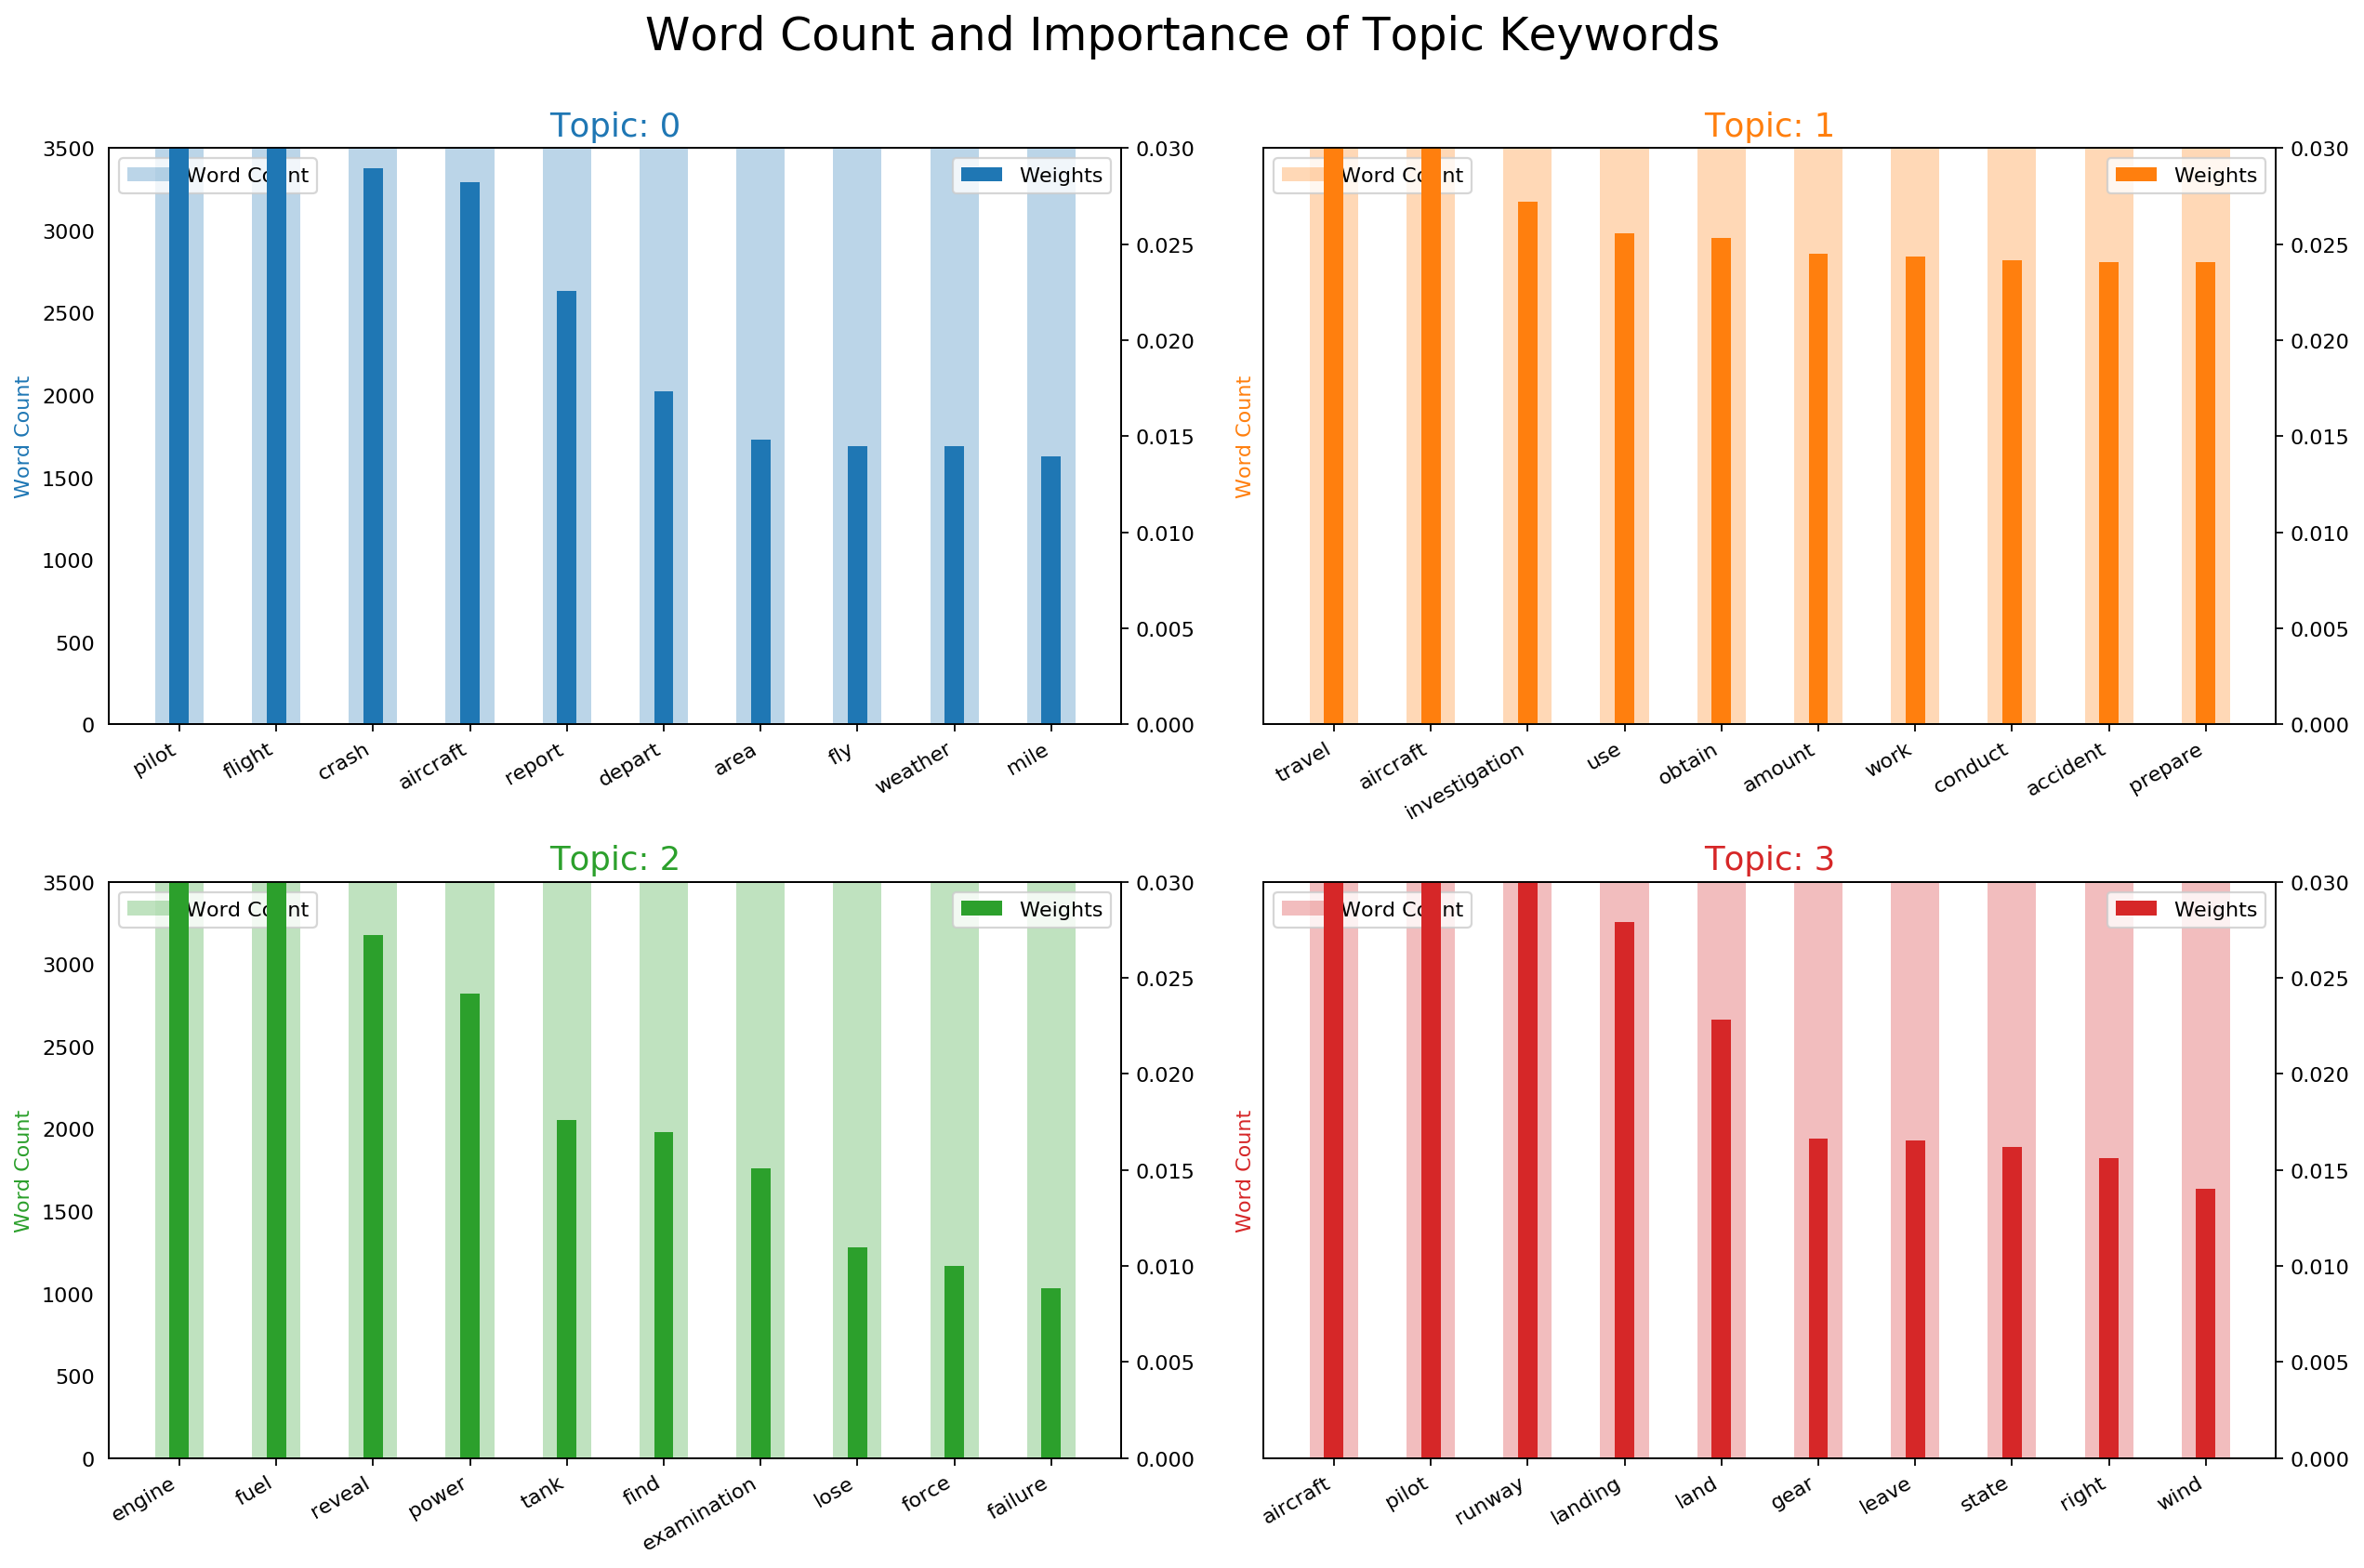

In [15]:
plot_topic_words(lda_model_narrative, term_vec_processed_narrative,2,2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 77255 samples in 0.042s...
[t-SNE] Computed neighbors for 77255 samples in 3.019s...
[t-SNE] Computed conditional probabilities for sample 1000 / 77255
[t-SNE] Computed conditional probabilities for sample 2000 / 77255
[t-SNE] Computed conditional probabilities for sample 3000 / 77255
[t-SNE] Computed conditional probabilities for sample 4000 / 77255
[t-SNE] Computed conditional probabilities for sample 5000 / 77255
[t-SNE] Computed conditional probabilities for sample 6000 / 77255
[t-SNE] Computed conditional probabilities for sample 7000 / 77255
[t-SNE] Computed conditional probabilities for sample 8000 / 77255
[t-SNE] Computed conditional probabilities for sample 9000 / 77255
[t-SNE] Computed conditional probabilities for sample 10000 / 77255
[t-SNE] Computed conditional probabilities for sample 11000 / 77255
[t-SNE] Computed conditional probabilities for sample 12000 / 77255
[t-SNE] Computed conditional probabilities for sam

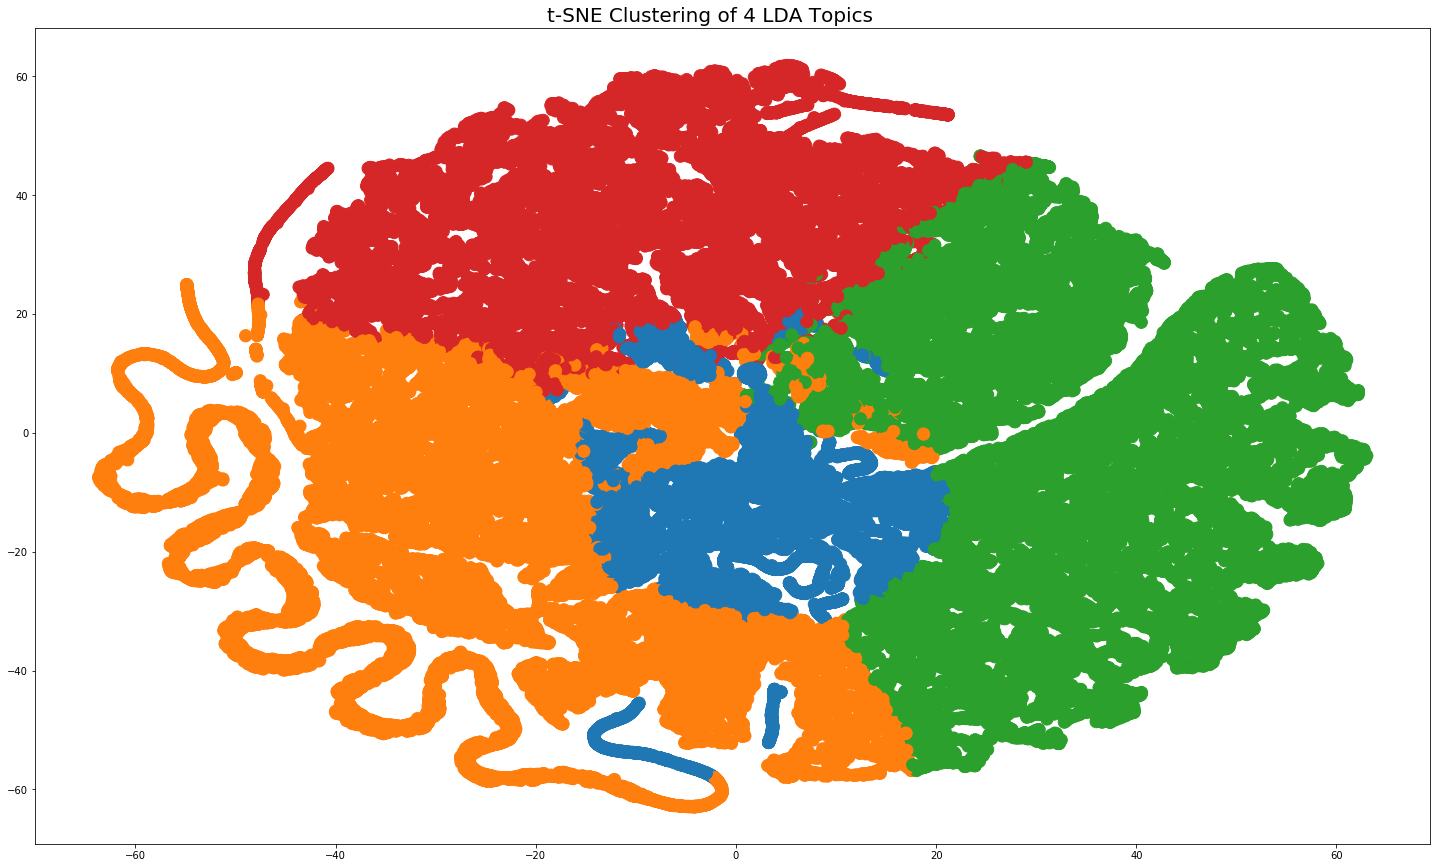

In [16]:
plot_document_topics_labeled(lda_model_narrative,corpus_narrative,4)

In [17]:
topic_weights_narrative = []
for i, row_list in enumerate(lda_model_narrative[corpus_narrative]):
    topic_weights_narrative.append([w for i, w in row_list[0]])

# Array of topic weights    
arr_narrative = pd.DataFrame(topic_weights_narrative).fillna(0).values

# Dominant topic number in each doc
topic_num_narrative = np.argmax(arr_narrative, axis=1)

In [44]:
combined_data['topic_num_narrative'] = topic_num_narrative

## Text Analytics on Cause

In [19]:
term_vec_cause = tokenize(cause)

In [20]:
term_vec_processed_cause = process_words(term_vec_cause)

In [142]:
term_vec_processed_cause_2000s = term_vec_processed_cause[0:29582]
term_vec_processed_cause_1985_2000 = term_vec_processed_cause[29583:66642]
term_vec_processed_cause_before_1985 = term_vec_processed_cause[66643: len(term_vec_processed_cause)]

In [147]:
term_vec_processed_cause_joined_2000 = [j for i in term_vec_processed_cause_2000s for j in i]
term_vec_processed_cause_joined_1985_2000 = [j for i in term_vec_processed_cause_1985_2000 for j in i]
term_vec_processed_cause_joined_before_1985 = [j for i in term_vec_processed_cause_before_1985 for j in i]

Counter_4 = Counter(term_vec_processed_cause_joined_2000)
Counter_5 = Counter(term_vec_processed_cause_joined_1985_2000) 
Counter_6 = Counter(term_vec_processed_cause_joined_before_1985) 
most_occur_4 = Counter_4.most_common(10) 
most_occur_5 = Counter_5.most_common(10) 
most_occur_6 = Counter_6.most_common(10) 
  
pprint(most_occur_4) 
pprint(most_occur_5) 
pprint(most_occur_6) 

[('pilot', 20690),
 ('failure', 14011),
 ('result', 11794),
 ('landing', 9847),
 ('maintain', 8935),
 ('loss', 7806),
 ('control', 7701),
 ('factor', 7573),
 ('engine', 6860),
 ('power', 5816)]
[('pilot', 20533),
 ('failure', 12438),
 ('factor', 12073),
 ('maintain', 7363),
 ('result', 6895),
 ('landing', 6853),
 ('accident', 6497),
 ('control', 5357),
 ('fuel', 5232),
 ('loss', 5138)]
[('pilot', 11),
 ('terrain', 9),
 ('condition', 9),
 ('factor', 7),
 ('maintenance', 6),
 ('flight', 5),
 ('failure', 5),
 ('accident', 5),
 ('inadequate', 5),
 ('contribute', 5)]


In [21]:
LDA_cause = LDA(term_vec_processed_cause, 4)
lda_model_cause = LDA_cause[0]
corpus_cause = LDA_cause[1]

/Users/Rachel/opt/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:821: RuntimeWarning: invalid value encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)
/Users/Rachel/opt/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:821: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


In [22]:
pprint(lda_model_cause.print_topics())

[(0,
  '0.038*"reason" + 0.035*"recognize" + 0.029*"unknown" + 0.027*"collision" + '
  '0.024*"need" + 0.024*"take" + 0.024*"sufficient" + 0.024*"stall" + '
  '0.024*"approach" + 0.013*"power"'),
 (1,
  '0.001*"unknown" + 0.001*"collision" + 0.000*"aircraft" + 0.000*"terrain" + '
  '0.000*"night" + 0.000*"mountainous" + 0.000*"recognize" + 0.000*"attempt" + '
  '0.000*"obscure" + 0.000*"know"'),
 (2,
  '0.061*"pilot" + 0.055*"condition" + 0.034*"terrain" + 0.030*"failure" + '
  '0.030*"instrument" + 0.030*"meteorological" + 0.025*"recognize" + '
  '0.025*"accident" + 0.024*"contribute" + 0.024*"mountainous"'),
 (3,
  '0.001*"unknown" + 0.001*"collision" + 0.000*"terrain" + 0.000*"night" + '
  '0.000*"mountainous" + 0.000*"recognize" + 0.000*"attempt" + 0.000*"obscure" '
  '+ 0.000*"know" + 0.000*"continue"')]


## Dominant Topics of Probable Cause:
### 0- undetermined, approach
### 1- terrain, night, obscure
### 2- instrumentation, pilot
### 3- very similar to topic 0 and 1

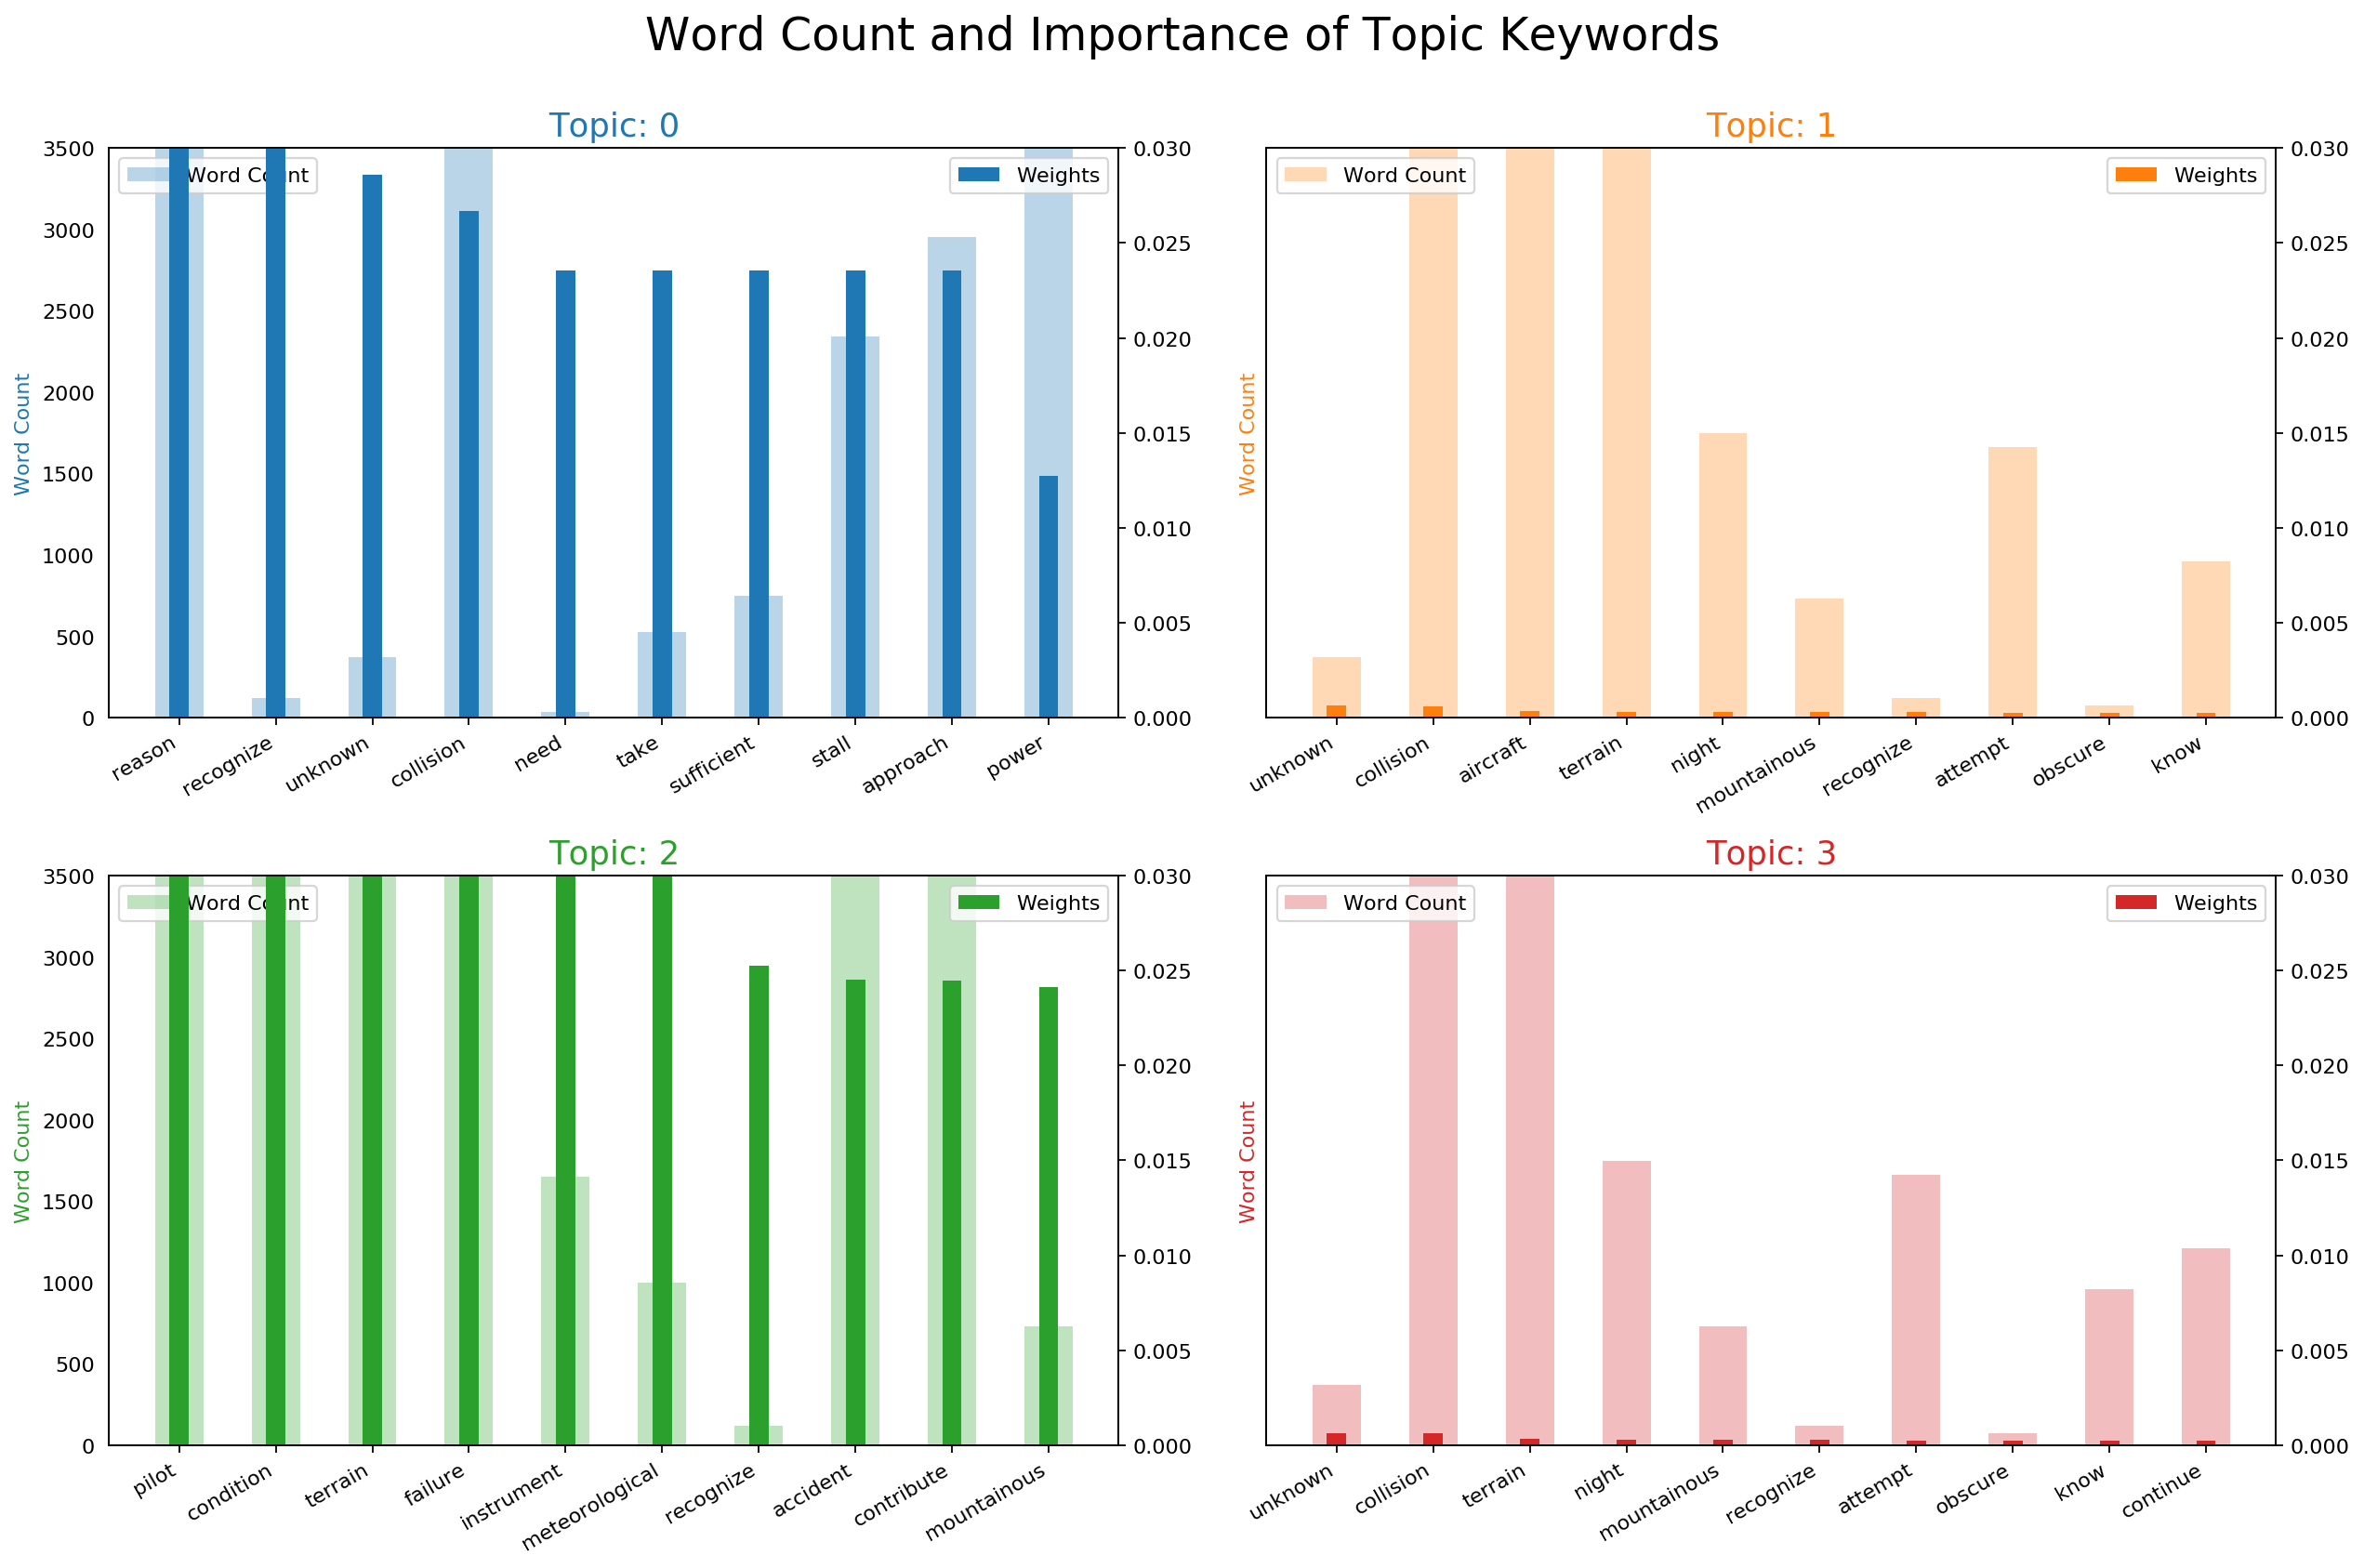

In [23]:
plot_topic_words(lda_model_cause, term_vec_processed_cause,2,2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 77255 samples in 1.430s...
[t-SNE] Computed neighbors for 77255 samples in 14.314s...
[t-SNE] Computed conditional probabilities for sample 1000 / 77255
[t-SNE] Computed conditional probabilities for sample 2000 / 77255
[t-SNE] Computed conditional probabilities for sample 3000 / 77255
[t-SNE] Computed conditional probabilities for sample 4000 / 77255
[t-SNE] Computed conditional probabilities for sample 5000 / 77255
[t-SNE] Computed conditional probabilities for sample 6000 / 77255
[t-SNE] Computed conditional probabilities for sample 7000 / 77255
[t-SNE] Computed conditional probabilities for sample 8000 / 77255
[t-SNE] Computed conditional probabilities for sample 9000 / 77255
[t-SNE] Computed conditional probabilities for sample 10000 / 77255
[t-SNE] Computed conditional probabilities for sample 11000 / 77255
[t-SNE] Computed conditional probabilities for sample 12000 / 77255
[t-SNE] Computed conditional probabilities for sa

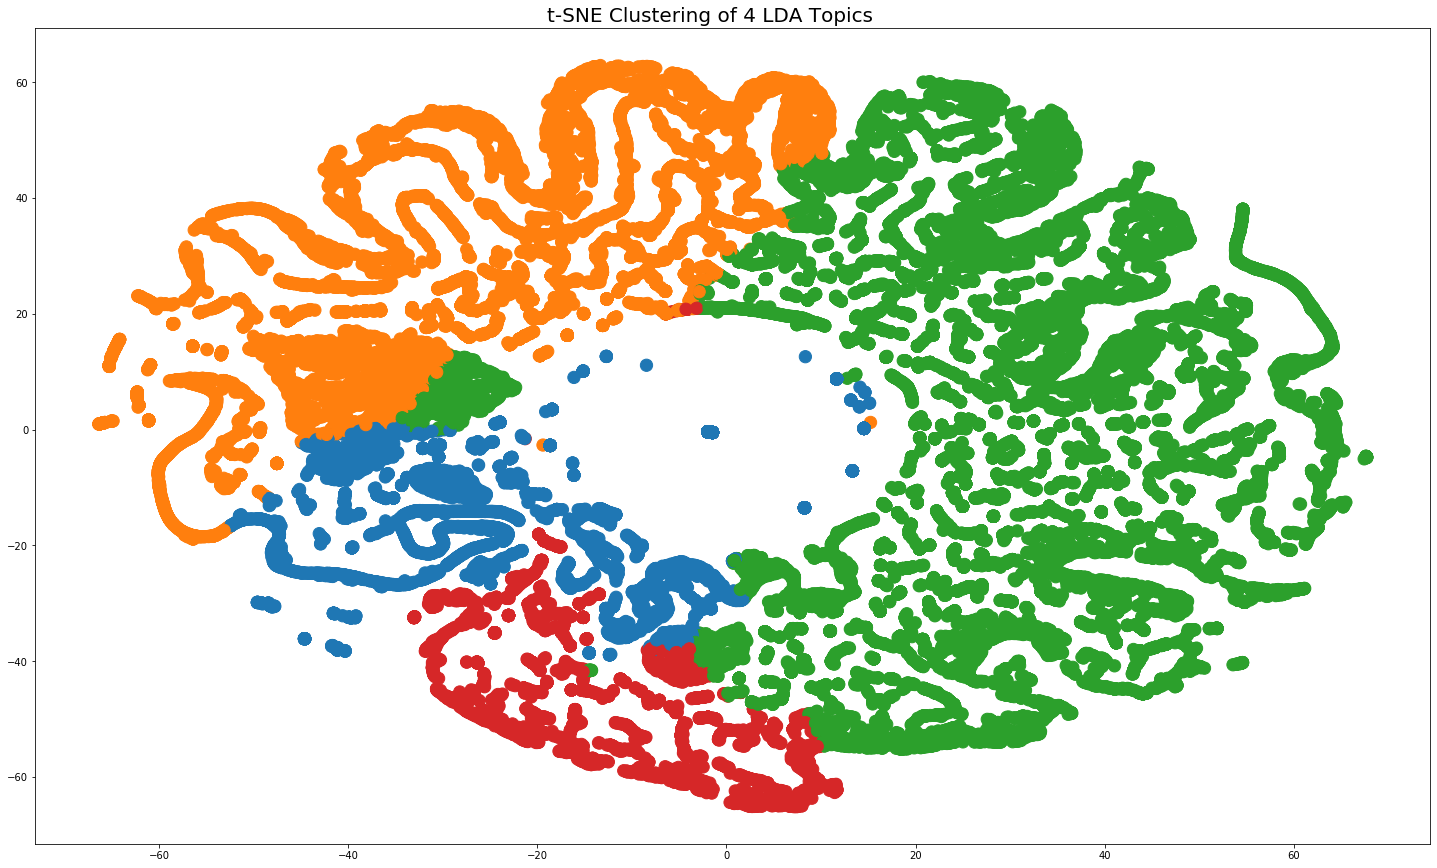

In [24]:
plot_document_topics_labeled(lda_model_cause,corpus_cause,4)

In [25]:
topic_weights_cause = []
for i, row_list in enumerate(lda_model_cause[corpus_cause]):
    topic_weights_cause.append([w for i, w in row_list[0]])

# Array of topic weights    
arr_cause = pd.DataFrame(topic_weights_cause).fillna(0).values

# Dominant topic number in each doc
topic_num_cause = np.argmax(arr_cause, axis=1)

In [45]:
combined_data['topic_num_cause'] = topic_num_cause

# Explore Topic Changes by Year

In [50]:
combined_data['topic_num_narrative'] = combined_data.apply(lambda row: 4 if pd.isnull(row['narrative']) else row['topic_num_narrative'],axis=1)

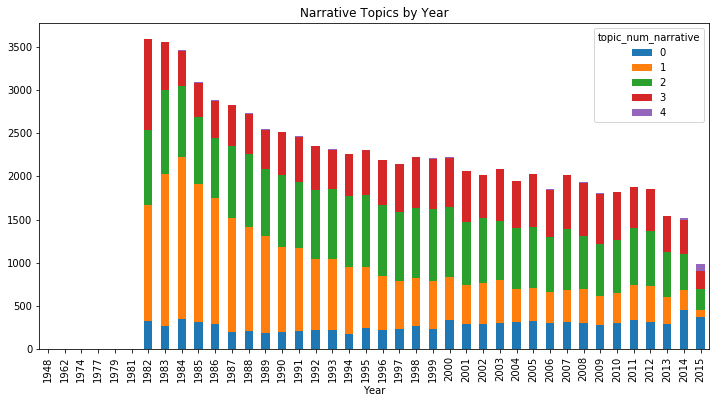

In [52]:
combined_data = combined_data.dropna(subset= ['Year'])
combined_data['Year'] = combined_data['Year'].astype(int)
topic_num_narrative_by_year = combined_data.groupby(['Year', 'topic_num_narrative']).size().unstack().plot(kind='bar', stacked=True,figsize = (12,6), title='Narrative Topics by Year')

In [53]:
combined_data['topic_num_cause'] = combined_data.apply(lambda row: 4 if pd.isnull(row['probable_cause']) else row['topic_num_cause'],axis=1)

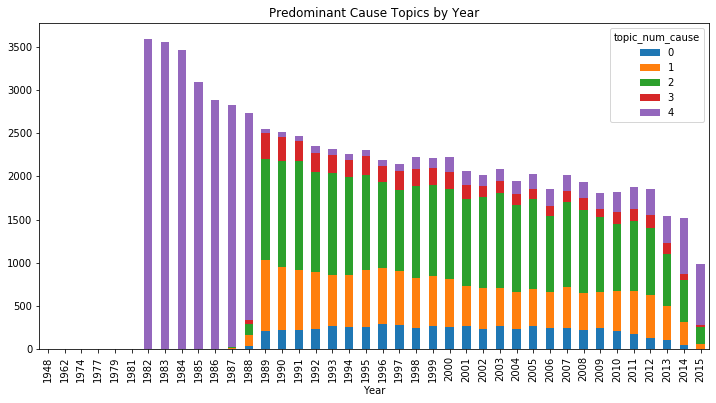

In [55]:
topic_num_cause_by_year = combined_data.groupby(['Year', 'topic_num_cause']).size().unstack().plot(kind='bar', stacked=True,figsize = (12,6), title='Predominant Cause Topics by Year')

In [56]:
combined_data.to_csv('Downloads/combined_aviation_data_topic_nums.csv')